In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATASET_PATH = "../dataset/CCPD2019/train/images"
CSV_PATH = "../dataset/CCPD2019/train/labels.csv"
OUTPUT_PATH = "../preprocessed_images/step_two_blue_plate_detection3"

# Create output directory if not exists
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Load CSV file
df = pd.read_csv(CSV_PATH)

# HSV Range for blue (Adjust if necessary)
LOWER_BLUE = np.array([67, 64, 70])  # Lower bound of blue in HSV
UPPER_BLUE = np.array([180, 255, 255])  # Upper bound of blue in HSV

# Function to detect and extract blue license plates
def detect_blue_plate(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return None, None

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Create mask for blue color
    mask = cv2.inRange(hsv, LOWER_BLUE, UPPER_BLUE)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Close gaps
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove noise

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the largest contour (assumed to be the plate)
    plate_contour = max(contours, key=cv2.contourArea, default=None)

    if plate_contour is not None and cv2.contourArea(plate_contour) > 500:
        x, y, w, h = cv2.boundingRect(plate_contour)
        plate_region = img[y:y+h, x:x+w]
        return mask, plate_region  # Return mask and extracted plate
    else:
        return mask, None  # No valid plate detected

# Process images
for i, row in df.iterrows():
    image_name = row["filename"]  # Ensure your CSV has a 'filename' column
    image_path = os.path.join(DATASET_PATH, image_name)

    mask, plate = detect_blue_plate(image_path)

    if mask is not None:
        # Save mask
        mask_path = os.path.join(OUTPUT_PATH, f"{os.path.splitext(image_name)[0]}_mask.jpg")
        cv2.imwrite(mask_path, mask)

    if plate is not None:
        # Save cropped plate region
        plate_path = os.path.join(OUTPUT_PATH, f"{os.path.splitext(image_name)[0]}_plate.jpg")
        cv2.imwrite(plate_path, plate)

    # Optional: Limit processing for quick testing
    if i == 10:
        print("Processed first 10 images for testing.")
        break

print("License plate detection complete. Results saved in:", OUTPUT_PATH)


Processed first 10 images for testing.
License plate detection complete. Results saved in: ../preprocessed_images/step_two_blue_plate_detection3


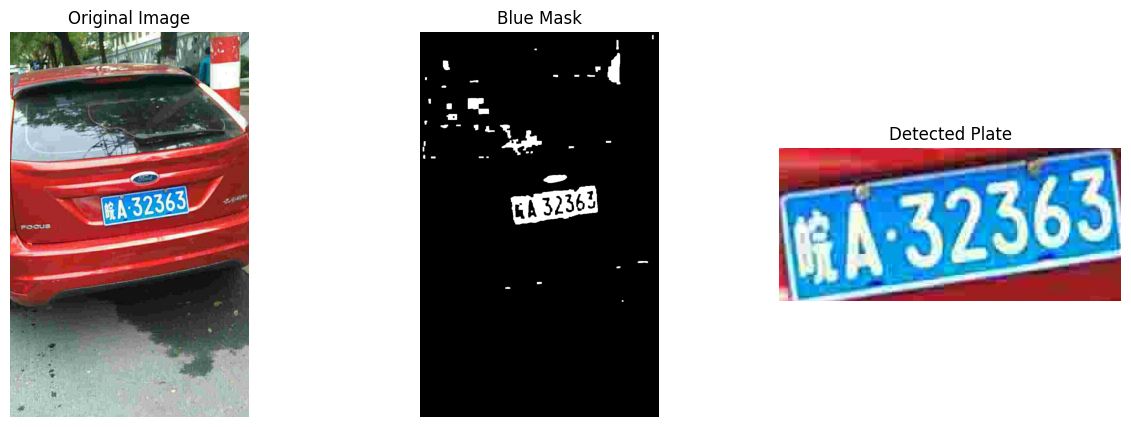

In [6]:
# Display example result
image_name = df.iloc[0]["filename"]
image_path = os.path.join(DATASET_PATH, image_name)

mask, plate = detect_blue_plate(image_path)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.imread(image_path)[..., ::-1]); ax[0].set_title("Original Image")
ax[1].imshow(mask, cmap="gray"); ax[1].set_title("Blue Mask")
ax[2].imshow(plate[..., ::-1]); ax[2].set_title("Detected Plate") if plate is not None else ax[2].set_title("No Plate Found")

for a in ax:
    a.axis("off")
plt.show()


In [13]:
import cv2
import numpy as np

# Load sample image
IMAGE_PATH = "../dataset/CCPD2019/train/images/0460464559386-86_92-238&480_549&628-551&607_242&629_243&492_552&470-0_0_24_33_25_10_25-75-118.jpg"
image = cv2.imread(IMAGE_PATH)

# Check if image was loaded correctly
if image is None:
    print("Error: Could not load image. Check the file path.")
    exit()

# Resize image for better visualization (adjust scale if needed)
scale_percent = 50  # Resize to 50% of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

# Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Callback function for trackbars
def nothing(x):
    pass

# Create a window
cv2.namedWindow("HSV Adjuster")

# Create trackbars for Hue, Saturation, and Value (min and max)
cv2.createTrackbar("Lower Hue", "HSV Adjuster", 90, 180, nothing)
cv2.createTrackbar("Lower Sat", "HSV Adjuster", 50, 255, nothing)
cv2.createTrackbar("Lower Val", "HSV Adjuster", 50, 255, nothing)
cv2.createTrackbar("Upper Hue", "HSV Adjuster", 140, 180, nothing)
cv2.createTrackbar("Upper Sat", "HSV Adjuster", 255, 255, nothing)
cv2.createTrackbar("Upper Val", "HSV Adjuster", 255, 255, nothing)

while True:
    # Get current trackbar positions
    l_h = cv2.getTrackbarPos("Lower Hue", "HSV Adjuster")
    l_s = cv2.getTrackbarPos("Lower Sat", "HSV Adjuster")
    l_v = cv2.getTrackbarPos("Lower Val", "HSV Adjuster")
    u_h = cv2.getTrackbarPos("Upper Hue", "HSV Adjuster")
    u_s = cv2.getTrackbarPos("Upper Sat", "HSV Adjuster")
    u_v = cv2.getTrackbarPos("Upper Val", "HSV Adjuster")

    # Create mask with updated HSV values
    lower_blue = np.array([l_h, l_s, l_v])
    upper_blue = np.array([u_h, u_s, u_v])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Apply bitwise AND to highlight detected regions
    result = cv2.bitwise_and(image, image, mask=mask)

    # Show results
    cv2.imshow("Original", image)
    cv2.imshow("Blue Mask", mask)
    cv2.imshow("Filtered Image", result)

    # Print current HSV values in console
    print(f"Lower HSV: [{l_h}, {l_s}, {l_v}] | Upper HSV: [{u_h}, {u_s}, {u_v}]", end="\r")

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cv2.destroyAllWindows()


KeyboardInterrupt: 

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def HSV_function(filename, LOWER_BLUE, UPPER_BLUE):
    OUTPUT_PATH = "../preprocessed_images3/cropped_plates/train/images"

    # Create output directory if not exists
    os.makedirs(OUTPUT_PATH, exist_ok=True)


    # Load image
    IMAGE_PATH = "../dataset/CCPD2019/train/images/" + filename
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        print("Error: Could not load image. Check the file path.")
        exit()

    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply thresholding to detect blue regions
    mask = cv2.inRange(hsv, LOWER_BLUE, UPPER_BLUE)

    # Try different kernel sizes dynamically
    kernel_sizes = [(5, 5), (3, 3), (7, 7)]
    for kernel_size in kernel_sizes:
        # Apply morphological operations to clean up the mask
        kernel = np.ones(kernel_size, np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Close small holes
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove noise

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Set aspect ratio range for license plates
        MIN_ASPECT_RATIO = 1.747  # Minimum width/height ratio (plates are rectangular)
        MAX_ASPECT_RATIO = 3.732  # Maximum width/height ratio

        MIN_AREA = 18000  # Minimum area to ignore small objects
        MAX_AREA = 170000  # Maximum area to ignore large objects

        # MIN_ASPECT_RATIO = 2.32  # Minimum width/height ratio (plates are rectangular)
        # MAX_ASPECT_RATIO = 3.93  # Maximum width/height ratio

        # MIN_AREA = 18000  # Minimum area to ignore small objects
        # MAX_AREA = 170000  # Maximum area to ignore large objects

        best_plate = None
        max_area = 0  # Track the largest detected plate

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Calculate aspect ratio (width / height)
            aspect_ratio = w / float(h)

            # Calculate contour area
            area = cv2.contourArea(contour)

            # Check if the detected contour matches a plate's expected shape
            if MIN_ASPECT_RATIO < aspect_ratio < MAX_ASPECT_RATIO and area > MIN_AREA and area < MAX_AREA:
                if area > max_area:  # Keep the largest valid plate
                    max_area = area
                    best_plate = (x, y, w, h)

        # Draw detected license plate
        output_image = image.copy()
        if best_plate:
            x, y, w, h = best_plate

            expansion = 0.10  # Expand by 10%
            x -= int(w * expansion)  # Expand left
            y -= int(h * expansion)  # Expand slightly up
            w += int(w * 2 * expansion)  # Expand width
            h += int(h * expansion)  # Expand height

            # **Ensure the bounding box is inside image boundaries**
            x = max(0, x)
            y = max(0, y)
            w = min(image.shape[1] - x, w)
            h = min(image.shape[0] - y, h)


            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle around plate

        #---------------------------------------------------------------------------

            box1 = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])
            box2 = parse_filename(filename)

        #---------------------------------------------------------------------------

            plate_region = image[y:y+h, x:x+w]  # Extract the detected plate
            accuracy = calculate_label_coverage(box1, box2)
            # accuracy = calculate_iou(box1, box2)

            if accuracy == 0:
                accuracy = 1
        else:
            plate_region = None
            accuracy = 0

        if best_plate:
            if plate_region is not None:
                # Save cropped plate region
                plate_path = os.path.join(OUTPUT_PATH, f"{filename}")
                cv2.imwrite(plate_path, plate_region)

            return accuracy

    # Display results
    # fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # ax[0].set_title("Original Image")

    # ax[1].imshow(mask, cmap="gray")
    # ax[1].set_title("Blue Mask")

    # ax[2].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    # ax[2].set_title("Detected License Plate")

    # for a in ax:
    #     a.axis("off")

    # plt.show()


    return accuracy


In [62]:
import shutil
import concurrent.futures
import numpy as np

def HSV_pipeline(filename):
    # Define the optimized HSV range for blue plates (update with your values)
    LOWER_BLUE = np.array([89, 125, 126])
    UPPER_BLUE = np.array([124, 255, 255])
    accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE)
    OUTPUT_PATH = "../preprocessed_images3/cropped_plates/train/images"

    # Create output directory if not exists
    os.makedirs(OUTPUT_PATH, exist_ok=True)

    if accuracy == 0:
        LOWER_BLUE = np.array([100, 70, 70])
        UPPER_BLUE = np.array([130, 255, 255])
        accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE)

    if accuracy == 0:
        LOWER_BLUE = np.array([84, 36, 56])
        UPPER_BLUE = np.array([165, 255, 255])
        accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE)

    if accuracy == 0:
        LOWER_BLUE = np.array([67, 64, 70])
        UPPER_BLUE = np.array([180, 255, 255])
        accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE)

    if accuracy == 0:
        LOWER_BLUE = np.array([81, 118, 52])
        UPPER_BLUE = np.array([176, 255, 255])
        accuracy = HSV_function(filename, LOWER_BLUE, UPPER_BLUE)

    if accuracy == 0:
        # Save full plate region
        src_path = os.path.join("../dataset/CCPD2019/train/images", filename)
        dest_path = os.path.join(OUTPUT_PATH, f"{filename}")
        shutil.copy(src_path, dest_path)


    return accuracy

def make_test():
    path = "../dataset/CCPD2019/train"
    accuracies= []

    # with open(f"{path}/file_names.txt", "r") as file:
    #     lines = file.readlines()
    #     i = 0
    #     n = len(lines)
    #     for filename in lines:
    #         i += 1
    #         accuracies.append(HSV_pipeline(filename.strip()))
    #         if i % 100 == 0:
    #             print(f"{(i / n) * 100:.2f}% ", end="\r")

    with open(f"{path}/file_names.txt", "r") as file:
        lines = file.readlines()
        n = len(lines)

    # Use ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:  # Adjust max_workers based on CPU
        accuracies = list(executor.map(lambda filename: HSV_pipeline(filename.strip()), lines))


    data = np.array(accuracies)

    mean = np.mean(data)
    count = np.count_nonzero(data)

    print("Overall Mean: ", mean)
    print("Overall Count: ", count)

    print("Correctness_score_above_zero: ", sum(data)/count)
    print("Overall Correct: ", count/len(data))
    print(data)

In [63]:
make_test()

# kernel_sizes = [(7, 7), (5, 5), (3, 3)]


Overall Mean:  85.72632239856061
Overall Count:  7106
Correctness_score_above_zero:  87.43940117432703
Overall Correct:  0.9804083885209713
[92.28395062 94.84978541 93.20269882 ... 91.26966036 99.66329966
 90.09444227]


In [57]:
make_test()

# expansion 10%

Overall Mean:  71.7981401808084
Overall Count:  7125
Correctness_score_above_zero:  73.03760281129811
Overall Correct:  0.9830298013245033
[77.31958763 75.77406419 73.2575979  ... 80.20309356 80.68934891
 68.92894488]


In [51]:
make_test()

#cal set

Overall Mean:  87.01463706212067
Overall Count:  866
Correctness_score_above_zero:  88.92373418011175
Overall Correct:  0.9785310734463277
[  0.          91.48262169  95.61403509 100.         100.
  91.21404254 100.          98.54545455 100.          84.61538462
  77.05433318   1.         100.           1.         100.
 100.          85.4368932   94.39252336  65.2722063   85.29411765
   1.           0.         100.          97.64046     53.92587262
  98.87640449   1.          99.66101695  83.33090379  39.43766186
 100.          46.01233609  92.87454115  86.80770554  57.94536672
  97.97979798  96.65292096  80.68576389  95.57129945  79.19067709
 100.          78.90642932 100.          91.41501688  95.99478147
  44.68475287  98.19494585  85.41114058 100.          96.3963964
  93.4512987  100.          95.53571429  89.25804575  94.32801461
  92.55319149  97.39130435  95.23809524  68.13412409  97.95221843
  96.69421488 100.          99.37106918 100.          99.35483871
  70.82326962  54.56

In [47]:
make_test()

# test set

Overall Mean:  85.46016881241964
Overall Count:  880
Correctness_score_above_zero:  87.20821771994635
Overall Correct:  0.9799554565701559
[ 99.04761905  96.77224256  79.83193277  95.78947368  85.32110092
 100.          87.32876712  20.48079018   1.          79.2920354
   1.          99.6124031   84.73026316   1.          96.24573379
  98.99665552  23.96802326  94.61363105  98.38187702  90.01126798
  91.85936015  21.07265765  84.68468468 100.         100.
 100.          14.64568705  59.81074481  20.93698544  97.30538922
  96.8168744   97.19899666  94.63917526  96.80851064  95.69892473
  92.91443044  98.03921569  95.70506539 100.          97.16981132
  32.00695803  96.84210526 100.          86.91588785 100.
 100.          98.45679012  91.75391608  98.02631579  89.62164447
   0.          98.65319865 100.          87.49792462  96.68674699
  67.66721763 100.          97.84172662  90.56603774   1.
  96.36363636   1.           1.          21.62922374  96.73913043
  99.11242604  95.28301887  

In [43]:
make_test()

# adjust aspect ratio to take tilt into account

# calculate_coverage

# # Set aspect ratio range for license plates
    # MIN_ASPECT_RATIO = 1.747  # Minimum width/height ratio (plates are rectangular)
    # MAX_ASPECT_RATIO = 3.732  # Maximum width/height ratio
    # MIN_AREA = 18000  # Minimum area to ignore small objects
    # MAX_AREA = 170000  # Maximum area to ignore large objects

Overall Mean:  86.58587413120347
Overall Count:  7125
Correctness_score_above_zero:  88.08061974778433
Overall Correct:  0.9830298013245033
[92.28395062 93.6440678  93.20269882 ... 95.09803922 99.32885906
 90.09444227]


In [33]:
make_test()

# calculate_coverage

# MIN_ASPECT_RATIO = 1.747  # Minimum width/height ratio (plates are rectangular)
# MAX_ASPECT_RATIO = 3.732  # Maximum width/height ratio

# Minimum area of license plates: 24973
# Maximum area of license plates: 170000

Overall Mean:  76.12529134755506
Overall Count:  6837
Correctness_score_above_zero:  80.70149359179155
Overall Correct:  0.9432947019867549
[92.28395062 93.6440678  93.20269882 ... 85.57805857 97.75011565
 90.09444227]


In [30]:
make_test()

# calculate_coverage

# MIN_ASPECT_RATIO = 1.747  # Minimum width/height ratio (plates are rectangular)
# MAX_ASPECT_RATIO = 3.732  # Maximum width/height ratio

# Minimum area of license plates: 24973
# Maximum area of license plates: 195579

Overall Mean:  76.00462578822722
Overall Count:  6841
Correctness_score_above_zero:  80.52646217118412
Overall Correct:  0.9438465783664459
[92.28395062 93.6440678  93.20269882 ... 85.57805857 97.75011565
 90.09444227]


In [25]:
make_test()

# calculate_iou

# MIN_ASPECT_RATIO = 1.747  # Minimum width/height ratio (plates are rectangular)
# MAX_ASPECT_RATIO = 3.732  # Maximum width/height ratio

# Minimum area of license plates: 24973
# Maximum area of license plates: 195579

Overall Mean:  0.7787368111648556
Overall Count:  6841
Correctness_score_above_zero:  0.8250671549953031
Overall Correct:  0.9438465783664459
[0.79273775 0.88285556 0.90696375 ... 0.85578059 0.95048047 0.8984614 ]


In [22]:
make_test()

# adjust aspect ratio to take tilt into account

# calculate_iou

# # Set aspect ratio range for license plates
    # MIN_ASPECT_RATIO = 1.747  # Minimum width/height ratio (plates are rectangular)
    # MAX_ASPECT_RATIO = 3.732  # Maximum width/height ratio
    # MIN_AREA = 18000  # Minimum area to ignore small objects
    # MAX_AREA = 170000  # Maximum area to ignore large objects

Overall Mean:  0.7963198527959567
Overall Count:  7125
Correctness_score_above_zero:  0.810066848149486
Overall Correct:  0.9830298013245033
[0.79273775 0.88285556 0.90696375 ... 0.76193159 0.92230993 0.8984614 ]


In [19]:
make_test()

# mit 3 different kernel sizes

# calculate_iou

# Overall Mean:  0.7670065871523376
# Overall Count:  6789
# Correctness_score_above_zero:  0.818863417834752
# Overall Correct:  0.9366721854304636
# [0.79273775 0.         0.90696375 ... 0.76193159 1.         0.8984614 ]

Overall Mean:  0.7670065871523376
Overall Count:  6789
Correctness_score_above_zero:  0.818863417834752
Overall Correct:  0.9366721854304636
[0.79273775 0.         0.90696375 ... 0.76193159 1.         0.8984614 ]


In [29]:
make_test()

# HSV_pipeline

    # MIN_ASPECT_RATIO = 2.32  # Minimum width/height ratio (plates are rectangular)
    # MAX_ASPECT_RATIO = 3.93  # Maximum width/height ratio
    # MIN_AREA = 16000  # Minimum area to ignore small objects
    # MAX_AREA = 175000  # Maximum area to ignore large objects

Overall Mean:  0.7565823879830437
Overall Count:  0
Correctness_score_above_zero:  inf
Overall Correct:  0.0
[0.79273775 0.         0.90696375 ... 0.76193159 1.         0.8984614 ]


/tmp/ipykernel_21284/942096453.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  print("Correctness_score_above_zero: ", sum(data)/count)


In [27]:
make_test()

# HSV_pipeline

    # MIN_ASPECT_RATIO = 2.32  # Minimum width/height ratio (plates are rectangular)
    # MAX_ASPECT_RATIO = 3.93  # Maximum width/height ratio
    # MIN_AREA = 16000  # Minimum area to ignore small objects
    # MAX_AREA = 175000  # Maximum area to ignore large objects

100/7248
200/7248
300/7248
400/7248
500/7248
600/7248
700/7248
800/7248
900/7248
1000/7248
1100/7248
1200/7248
1300/7248
1400/7248
1500/7248
1600/7248
1700/7248
1800/7248
1900/7248
2000/7248
2100/7248
2200/7248
2300/7248
2400/7248
2500/7248
2600/7248


KeyboardInterrupt: 

In [20]:
make_test()

Overall Mean:  0.7565823879830437
Overall Count:  6717
Correctness_score_above_zero:  0.8163926080245797
Overall Correct:  0.9267384105960265
[0.79273775 0.         0.90696375 ... 0.76193159 1.         0.8984614 ]


In [6]:
make_test()

# HSV_pipeline

# MIN_ASPECT_RATIO = 2.32  # Minimum width/height ratio (plates are rectangular)
# MAX_ASPECT_RATIO = 3.93  # Maximum width/height ratio
# MIN_AREA = 18000  # Minimum area to ignore small objects
# MAX_AREA = 170000  # Maximum area to ignore large objects


Overall Mean:  78.12116715335391
Overall Count:  6674
Correctness_score_above_zero:  84.8400089193151
Overall Correct:  0.9208057395143487


In [47]:
make_test()

# HSV_pipeline

# Overall Mean:  78.05314838955701
# Overall Count:  6181
# Correctness_score_above_zero:  91.52713469139447
# Overall Correct:  0.8527869757174393

Overall Mean:  79.22935119717293
Overall Count:  6343
Correctness_score_above_zero:  90.53355470236623
Overall Correct:  0.8751379690949227


In [24]:
make_test()
# # Lower bound for "blue"
# lower_blue = (100, 70, 70)   # (H_min, S_min, V_min)
# # Upper bound for "blue"
# upper_blue = (130, 255, 255) # (H_max, S_max, V_max)


Overall Mean:  52.782317604754326
Overall Count:  4411
Correctness_score_above_zero:  86.73004715467222
Overall Correct:  0.6085816777041942


In [20]:
make_test()

# LOWER_BLUE = np.array([89, 125, 126])  # Replace with your tuned values
#     UPPER_BLUE = np.array([124, 255, 255])


Overall Mean:  52.12083804616621
Overall Count:  3958
Overall Correct:  95.44513243017003
Correctness_score_above_zero:  0.5460816777041942


In [26]:
make_test()

# LOWER_BLUE = np.array([84, 36, 56])  # Replace with your tuned values
#   UPPER_BLUE = np.array([165, 255, 255])

Overall Mean:  48.294491672448835
Overall Count:  4206
Correctness_score_above_zero:  83.22360333854252
Overall Correct:  0.5802980132450332


In [33]:
make_test()

#1.
# # LOWER_BLUE = np.array([89, 125, 126])  # Replace with your tuned values
# UPPER_BLUE = np.array([124, 255, 255])

# 2.
# LOWER_BLUE = np.array([67, 64, 70])  # Replace with your tuned values
# UPPER_BLUE = np.array([180, 255, 255])

Mean:  71.57432489920141
Count:  5668
Correct:  0.7820088300220751


In [9]:
make_test()

#1.
# # LOWER_BLUE = np.array([89, 125, 126])  # Replace with your tuned values
# UPPER_BLUE = np.array([124, 255, 255])

# 2.
# LOWER_BLUE = np.array([67, 64, 70])  # Replace with your tuned values
# UPPER_BLUE = np.array([180, 255, 255])

# 3.
# LOWER_BLUE = np.array([84, 36, 56])  # Replace with your tuned values
# UPPER_BLUE = np.array([165, 255, 255])

Mean:  74.4875462493071
Count:  5926
Correct:  0.8176048565121413


In [16]:
make_test()

#1.
# # LOWER_BLUE = np.array([89, 125, 126])  # Replace with your tuned values
# UPPER_BLUE = np.array([124, 255, 255])

# 2.
# LOWER_BLUE = np.array([67, 64, 70])  # Replace with your tuned values
# UPPER_BLUE = np.array([180, 255, 255])

# 3.
# LOWER_BLUE = np.array([84, 36, 56])  # Replace with your tuned values
# UPPER_BLUE = np.array([165, 255, 255])

# 4.
# LOWER_BLUE = np.array([81, 118, 52])  # Replace with your tuned values
# UPPER_BLUE = np.array([176, 255, 255])


Mean:  75.36705201737243
Count:  6030
Correct:  0.831953642384106


In [36]:
make_test()

Overall Mean:  78.05314838955701
Overall Count:  6181
Correctness_score_above_zero:  91.52713469139447
Overall Correct:  0.8527869757174393


In [6]:
import cv2
import numpy as np
import json
import os

# === Load Ground Truth Labels (if available) ===
def load_ground_truth(json_path):
    """Loads a JSON file containing ground truth bounding box coordinates."""
    with open(json_path, "r") as file:
        return json.load(file)

# === Image Preprocessing ===
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (640, 480))

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE for better contrast
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(32, 32))
    gray = clahe.apply(gray)

    # Apply bilateral filter
    bilateral = cv2.bilateralFilter(gray, 64, 1, 1)

    # Image sharpening
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    bilateral = cv2.filter2D(bilateral, -1, kernel)

    # Brightness and contrast adjustment
    bilateral = cv2.convertScaleAbs(bilateral, alpha=1.5, beta=1.5)

    return img, gray, bilateral

# === License Plate Detection ===
def detect_license_plate(img):
    """Detects the largest rectangular contour that could be a license plate."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 150)  # Edge detection

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    plate_bbox = None
    max_area = 0

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

        if len(approx) == 4:  # Check for rectangular shape
            x, y, w, h = cv2.boundingRect(approx)
            area = w * h

            # Heuristic: License plates are usually wider than tall
            if 2.0 < w / h < 5.0 and area > max_area:
                plate_bbox = (x, y, w, h)
                max_area = area

    return plate_bbox  # Returns the best detected plate bounding box (x, y, width, height)

# === Accuracy Check ===
def check_detection_accuracy(detected_bbox, ground_truth_bbox):
    """Compares the detected bounding box with ground truth."""
    if detected_bbox is None:
        return False  # No detection made

    x1, y1, w1, h1 = detected_bbox
    x2, y2, w2, h2 = ground_truth_bbox

    # Calculate Intersection over Union (IoU) for accuracy
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)

    intersection = max(0, xB - xA) * max(0, yB - yA)
    union = (w1 * h1) + (w2 * h2) - intersection

    iou = intersection / union if union > 0 else 0

    return iou > 0.5  # Consider correct if IoU > 50%

# === Process Images ===
base_path = "../dataset/CCPD2019"  # Adjust to your dataset path
ground_truth_path = f"{base_path}/train/ground_truth.json"  # JSON with bounding boxes

# Load ground truth if available
ground_truth = load_ground_truth(ground_truth_path)

correct_count = 0
total_count = 0

with open(f"{base_path}/train/file_names.txt", "r") as file:
    lines = file.readlines()

    for filename in lines:
        filename = filename.strip()  # Remove newline characters
        image_path = f"{base_path}/train/images/{filename}"

        if filename not in ground_truth:
            print(f"No ground truth for {filename}, skipping...")
            continue

        img, gray, bilateral = preprocess_image(image_path)
        detected_bbox = detect_license_plate(img)
        ground_truth_bbox = ground_truth[filename]  # Expected bounding box

        # Check if detection is correct
        if check_detection_accuracy(detected_bbox, ground_truth_bbox):
            correct_count += 1

        total_count += 1

# === Accuracy Report ===
accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
print(f"Detection Accuracy: {accuracy:.2f}% ({correct_count}/{total_count} correct)")


FileNotFoundError: [Errno 2] No such file or directory: '../dataset/CCPD2019/train/ground_truth.json'

In [2]:
import pandas as pd

def parse_filename(filename):
    """Extract ground truth coordinates from filename"""
    parts = filename.split('-')
    if len(parts) < 3:
        return None

    try:
        # Get bounding box coordinates
        bbox = parts[2].split('_')
        if len(bbox) != 2:
            return None

        # Parse coordinates
        top_left, bottom_right = bbox[0].split('&'), bbox[1].split('&')
        x1, y1 = map(int, top_left)
        x2, y2 = map(int, bottom_right)

        return np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.int32)
    except:
        return None

def four_vertices_locations(base_path):
    # Load CSV file (assumes columns: filename, x, y, w, h)
    csv_path = f"{base_path}/labels.csv"
    df = pd.read_csv(csv_path)

    # Convert to dictionary format
    image_dict = {row["filename"]: parse_filename(row["filename"]) for _, row in df.iterrows()}

    # Print the dictionary
    print(image_dict)

base_path = "../dataset/CCPD2019/train"  # Adjust to your dataset path

In [27]:
import numpy as np
import cv2

def calculate_label_coverage(label, green_box):
    """
    Calculate how much (in %) of the labeled box is inside the green_box.

    :param label:     Nx2 array of polygon points (e.g., [[x1,y1], [x2,y2], ...])
    :param green_box: Nx2 array of polygon points
    :return:          Percentage (float) of how much the labeled box is covered by the green box
    """
    # Determine the max height/width needed for the mask
    max_y = max(np.max(label[:, 1]), np.max(green_box[:, 1]))
    max_x = max(np.max(label[:, 0]), np.max(green_box[:, 0]))

    # Create empty masks
    mask_label = np.zeros((max_y + 1, max_x + 1), dtype=np.uint8)
    mask_green = np.zeros((max_y + 1, max_x + 1), dtype=np.uint8)

    # Fill polygons on each mask
    cv2.fillPoly(mask_label, [label], 1)
    cv2.fillPoly(mask_green, [green_box], 1)

    # Compute intersection (overlapping area)
    intersection = np.logical_and(mask_label, mask_green).sum()

    # Compute area of the label box
    label_area = mask_label.sum()

    # Avoid division by zero if label_area is 0
    if label_area == 0:
        return 0.0

    # Calculate percentage of label covered by the green box
    coverage_percentage = (intersection / label_area) * 100.0

    return coverage_percentage


In [4]:
def calculate_iou(box1, box2):
    """Calculate Intersection over Union between two bounding boxes"""
    # Create binary masks for both boxes
    h, w = max(np.max(box1[:, 1]), np.max(box2[:, 1])), max(np.max(box1[:, 0]), np.max(box2[:, 0]))
    mask1 = np.zeros((h+1, w+1), dtype=np.uint8)
    mask2 = np.zeros((h+1, w+1), dtype=np.uint8)

    # Fill masks
    cv2.fillPoly(mask1, [box1], 1)
    cv2.fillPoly(mask2, [box2], 1)

    # Calculate intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    return intersection / union if union > 0 else 0